# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimers  ADNI Detection </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [VGG16 Model](#10)
* [Evaluate The Model](#11)


**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

2024-08-14 11:04:18.761205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 11:04:18.761311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 11:04:18.876811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [3]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/kmeans-nonsegm')):
    subfolder_path = os.path.join('/kaggle/input/kmeans-nonsegm', subfolder)
    for folder in os.listdir(subfolder_path):
        # subfolder_path2=os.path.join(subfolder_path,folder)
        # for image_filename in os.listdir(subfolder_path2):
        image_path = os.path.join(subfolder_path, folder)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 3/3 [00:00<00:00, 71.04it/s]


,image,label
0,/kaggle/input/kmeans-nonsegm/MCI/I20004_slice_...,MCI
1,/kaggle/input/kmeans-nonsegm/MCI/I46884_slice_...,MCI
2,/kaggle/input/kmeans-nonsegm/MCI/I137797_slice...,MCI
3,/kaggle/input/kmeans-nonsegm/MCI/I263034_slice...,MCI
4,/kaggle/input/kmeans-nonsegm/MCI/I56913_slice_...,MCI
...,...,...
15326,/kaggle/input/kmeans-nonsegm/CN/I399701_slice_...,CN
15327,/kaggle/input/kmeans-nonsegm/CN/I476648_slice_...,CN
15328,/kaggle/input/kmeans-nonsegm/CN/I157178_slice_...,CN
15329,/kaggle/input/kmeans-nonsegm/CN/I71098_slice_0...,CN


In [4]:
df1=df[(df['label']=='CN') | (df['label']=='AD') ]
df = df1

In [5]:
import pandas as pd


print(df['label'].value_counts())

# Trouver la taille de la plus petite classe
min_class_size = df['label'].value_counts().min()

# Échantillonner chaque classe pour obtenir le même nombre d'images
df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

# Afficher la distribution finale des étiquettes
print(df_balanced['label'].value_counts())


label
AD    5232
CN    5076
Name: count, dtype: int64
label
AD    5076
CN    5076
Name: count, dtype: int64


/tmp/ipykernel_34/2449948185.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


In [6]:
df=df_balanced

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

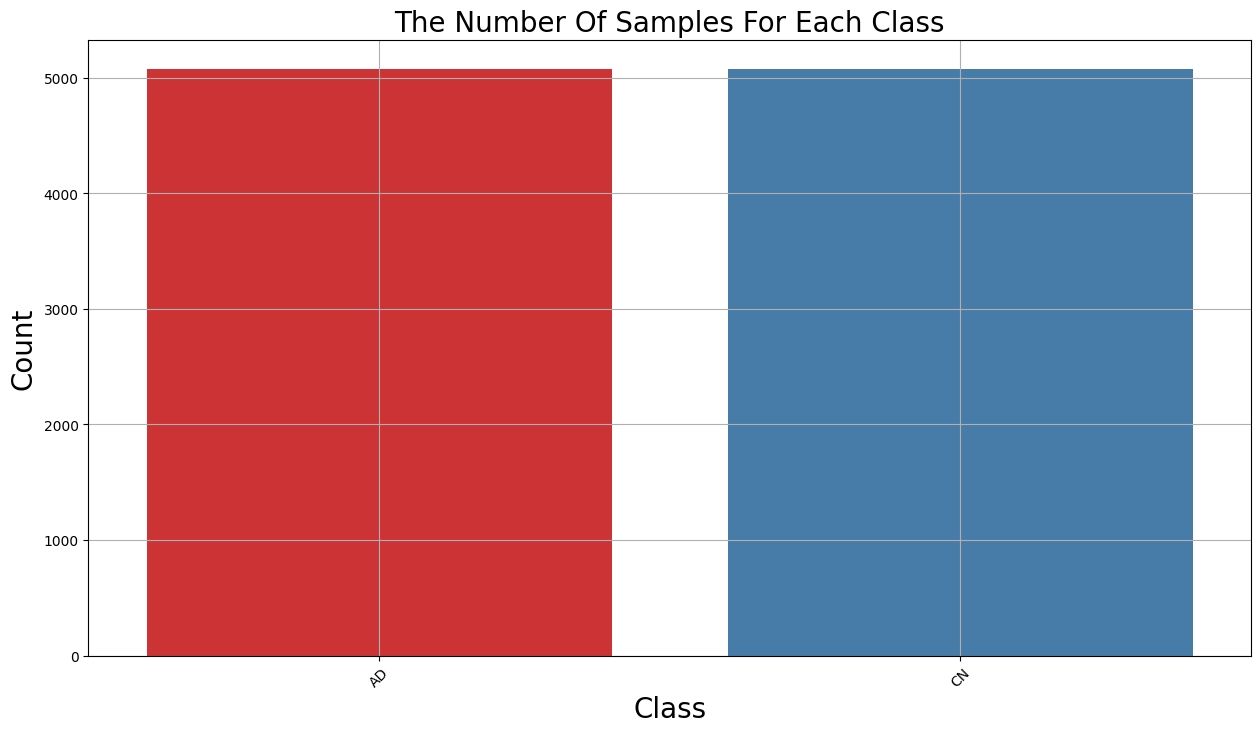

In [7]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Data Augmentation </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [8]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [17]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
#     rescale=1./255
#     horizontal_flip=True,
#     rotation_range=10,        # Utiliser une petite plage de rotation
#     width_shift_range=0.1,    # Décalage horizontal modéré
#     height_shift_range=0.1,   # Décalage vertical modéré
#     # shear_range=0.1,          # Cisaillement modéré
#     zoom_range=0.1,           # Zoom modéré
#     # brightness_range=[0.8, 1.2], # Variation de luminosité
#     fill_mode='nearest'       # Méthode de remplissage des pixels générés
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 8121 validated image filenames belonging to 2 classes.
Found 1016 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

# Création du générateur de données sans prétraitement complexe
datagen = ImageDataGenerator(
    rescale=1./255  # Normalisation des valeurs des pixels entre 0 et 1
)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Générateur pour le test
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 12264 validated image filenames belonging to 3 classes.
Found 1534 validated image filenames belonging to 3 classes.
Found 1533 validated image filenames belonging to 3 classes.


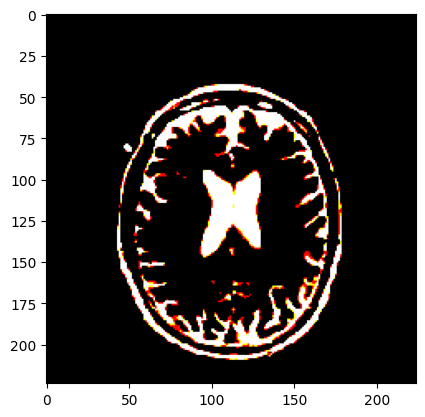

In [18]:
import matplotlib.pyplot as plt

# Obtenir une image du générateur
sample_image, _ = next(train_generator)

# Afficher l'image
plt.imshow(sample_image[5])
plt.show()


In [19]:
class_num=list(train_generator.class_indices.keys())
class_num

['AD', 'CN']

In [ ]:
from tensorflow.keras import layers, models

# Initialiser le modèle séquentiel
model = models.Sequential()

# Convolution Layer 1
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 2
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(2, 2)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 5
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten pour passer aux couches entièrement connectées
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))

# Ajouter la couche de sortie pour la classification (par exemple, softmax pour 3 classes)
model.add(layers.Dense(2, activation='softmax'))

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


In [ ]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
# model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">VGG16 Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [21]:
model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la première couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la deuxième couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2, activation='softmax'))
model.layers[0].trainable = False
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              1050624   
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.models import Model

# Charger le modèle VGG16 avec les poids pré-entraînés d'ImageNet
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')

# Créez un modèle fonctionnel
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Assurez-vous que base_model ne soit pas en mode entraînement
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

# Geler les poids du modèle VGG16 pré-entrainé
base_model.trainable = False

model.summary()


In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pour sauvegarder les meilleurs poids
checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)

# Early stopping pour éviter le surapprentissage
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Scheduler pour réduire le taux d'apprentissage en cas de stagnation
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Compiler le modèle avec l'optimiseur Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les callbacks ajustés
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])


In [ ]:
from tensorflow.keras.optimizers import SGD
# Using SGD optimizer with lower learning rate and momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)  # Increase patience

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

In [22]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200


I0000 00:00:1723633710.930593     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


254/254 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.7913

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - 79s 260ms/step - loss: 0.5952 - accuracy: 0.7913 - val_loss: 0.3197 - val_accuracy: 0.8690
Epoch 2/200
254/254 [==============================] - 38s 150ms/step - loss: 0.2744 - accuracy: 0.8846 - val_loss: 0.2417 - val_accuracy: 0.8956
Epoch 3/200
254/254 [==============================] - 41s 162ms/step - loss: 0.2059 - accuracy: 0.9206 - val_loss: 0.1891 - val_accuracy: 0.9222
Epoch 4/200
254/254 [==============================] - 40s 158ms/step - loss: 0.1466 - accuracy: 0.9427 - val_loss: 0.2201 - val_accuracy: 0.9163
Epoch 5/200
254/254 [==============================] - 41s 160ms/step - loss: 0.1188 - accuracy: 0.9512 - val_loss: 0.2696 - val_accuracy: 0.9133
Epoch 6/200
254/254 [==============================] - 41s 160ms/step - loss: 0.1080 - accuracy: 0.9602 - val_loss: 0.2439 - val_accuracy: 0.9360
Epoch 7/200
254/254 [==============================] - 41s 161ms/step - loss: 0.0888 - accuracy: 0.9674 - val_loss: 0.1824 - val_accurac

<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [30]:
model.save('/kaggle/working/modele_checkpoint.h5')
print("Le modèle a été sauvegardé sous le nom 'mon_modele.h5'")

Le modèle a été sauvegardé sous le nom 'mon_modele.h5'


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.595204,0.791282,0.319704,0.868966
1,0.274441,0.884620,0.241707,0.895567
2,0.205861,0.920576,0.189074,0.922167
3,0.146614,0.942741,0.220136,0.916256
4,0.118774,0.951238,0.269559,0.913301
5,0.108012,0.960227,0.243863,0.935961
6,0.088752,0.967369,0.182414,0.943842
7,0.078224,0.972048,0.148816,0.942857
8,0.077825,0.971063,0.145233,0.951724
9,0.070962,0.974264,0.175235,0.940887


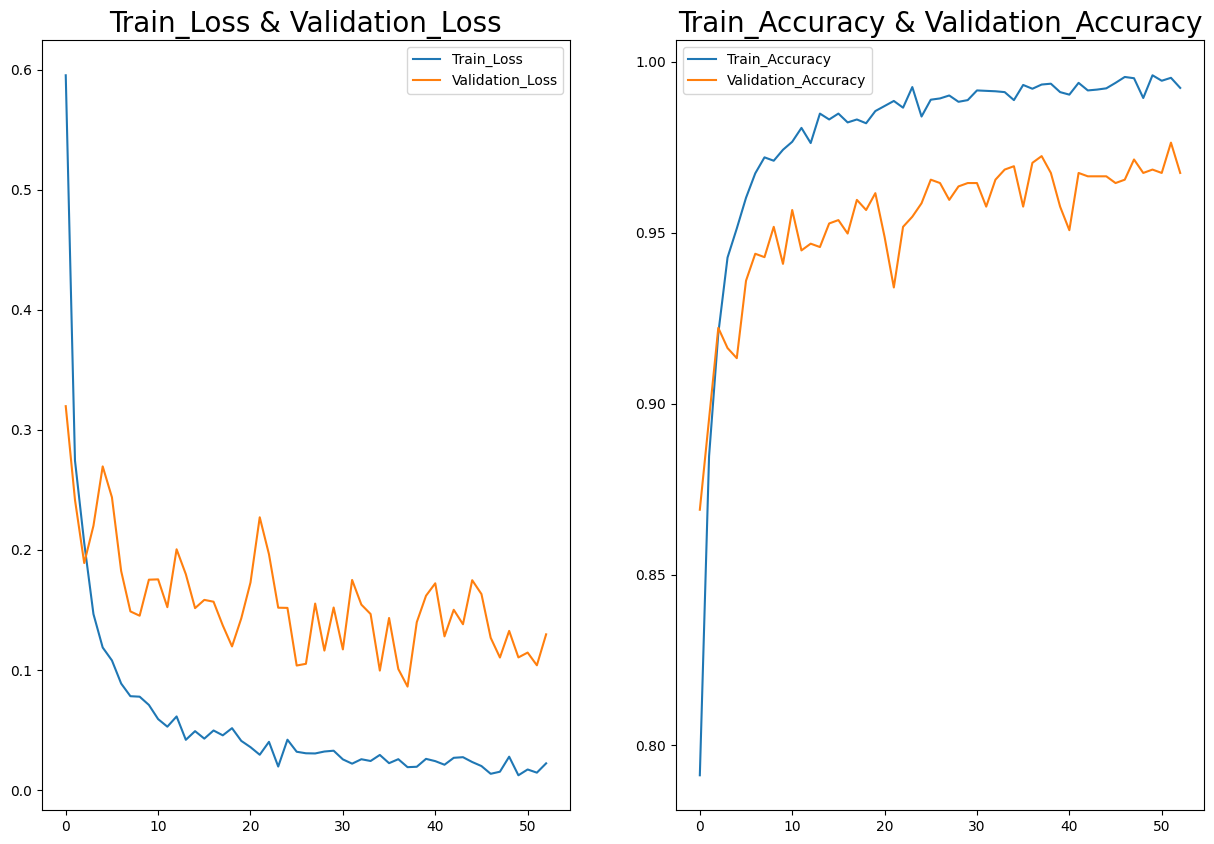

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [25]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

32/32 [==============================] - 14s 441ms/step - loss: 0.1014 - accuracy: 0.9616
Test Loss = 0.10137563943862915
Test Accuracy = 0.961614191532135


In [26]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

32/32 [==============================] - 5s 141ms/step


,Actual,Prediction
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
1011,1,1
1012,1,1
1013,1,1
1014,0,0


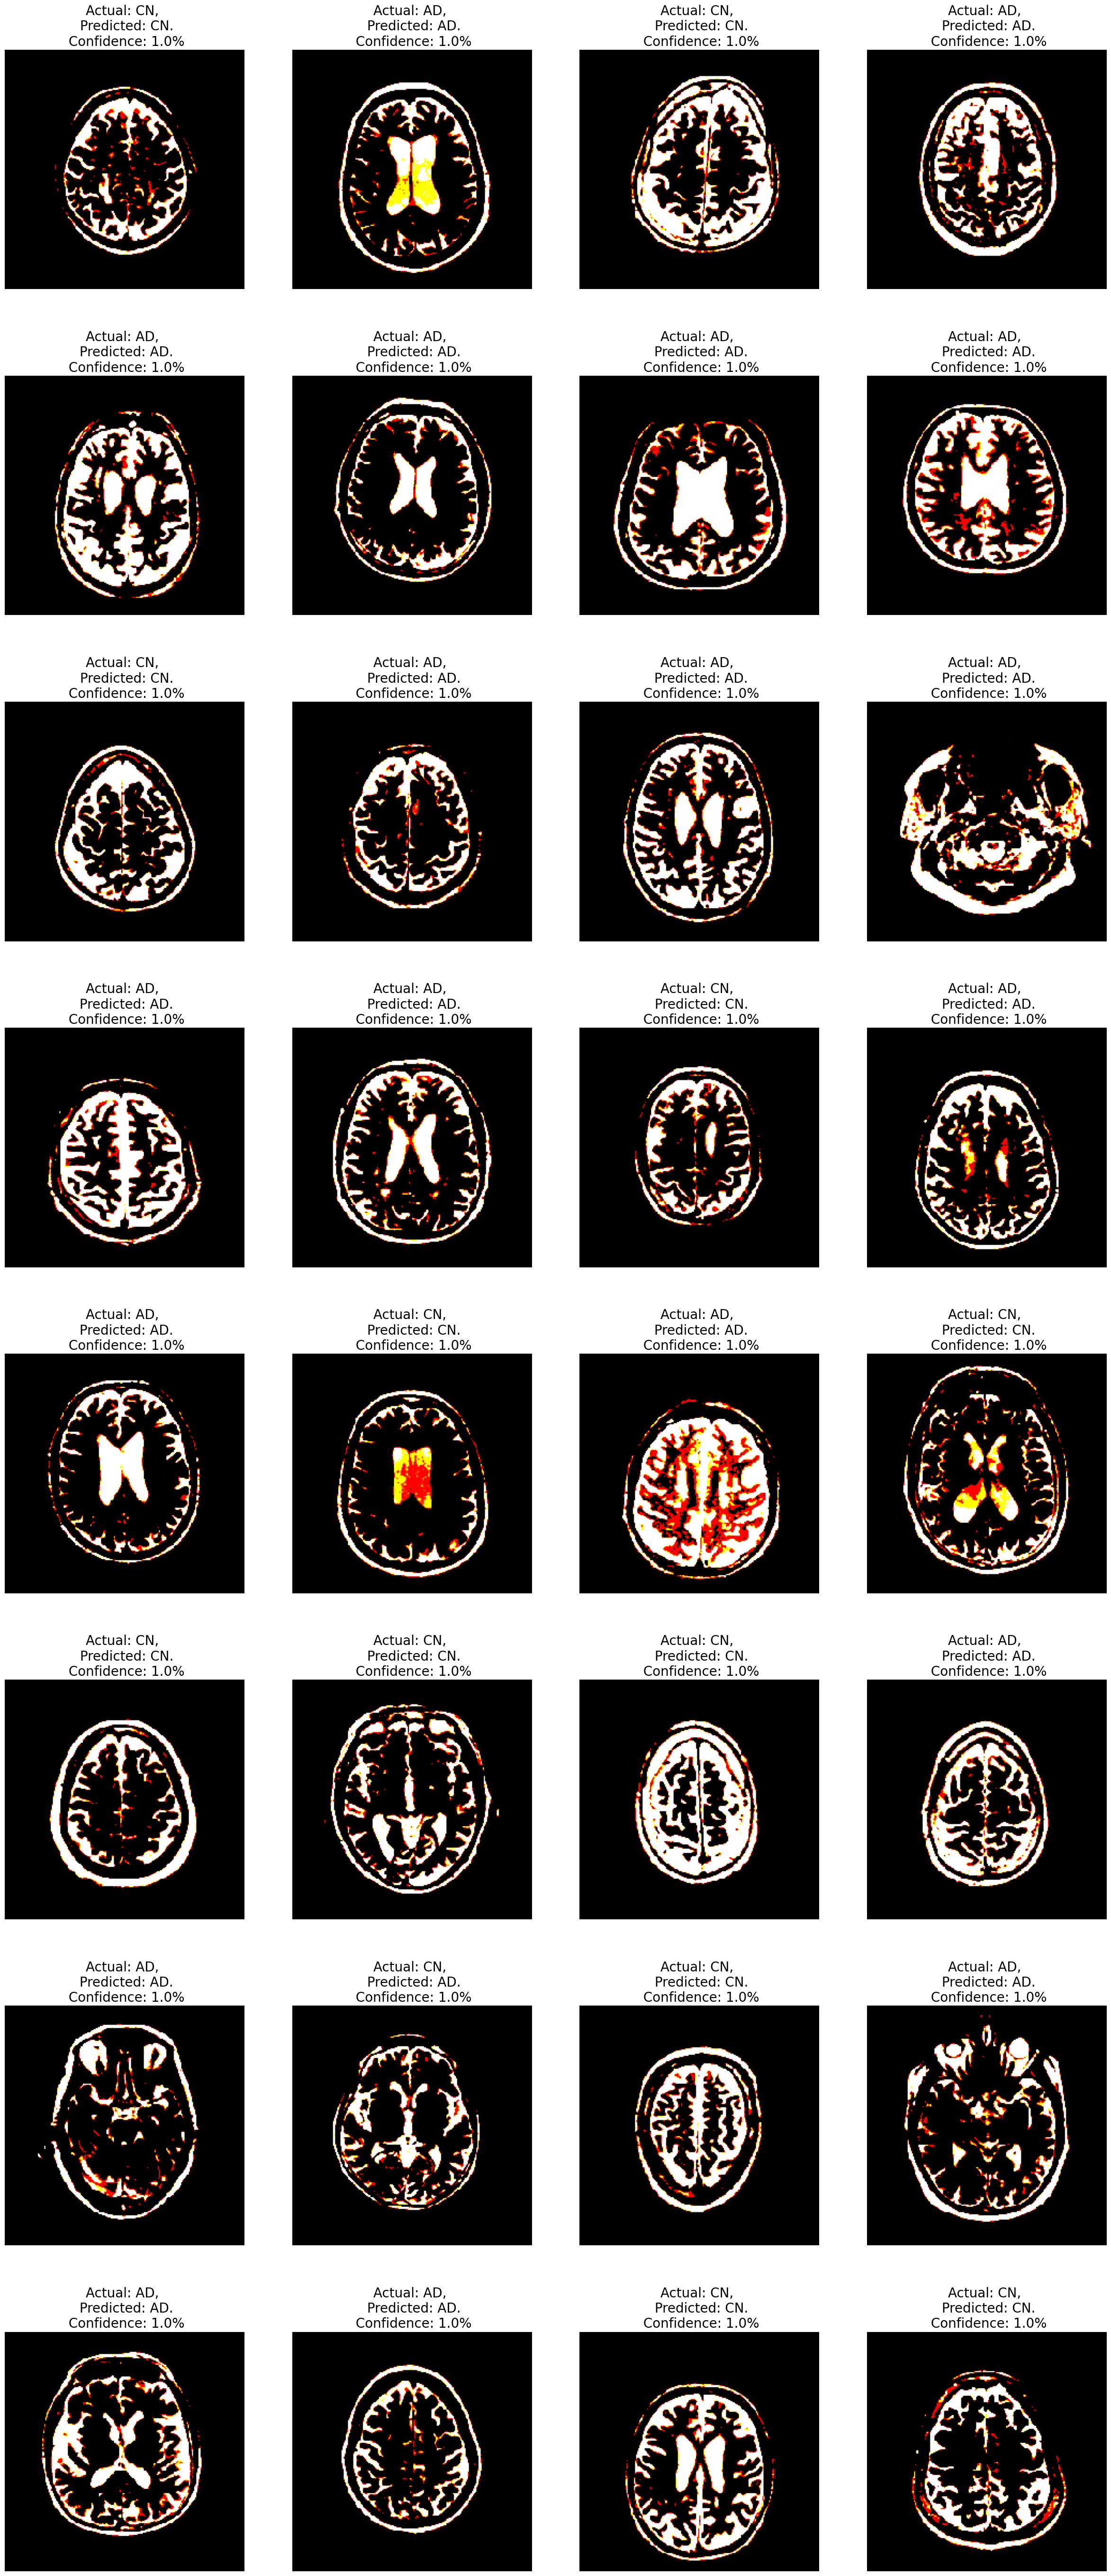

In [27]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

array([[480,  28],
       [ 11, 497]])

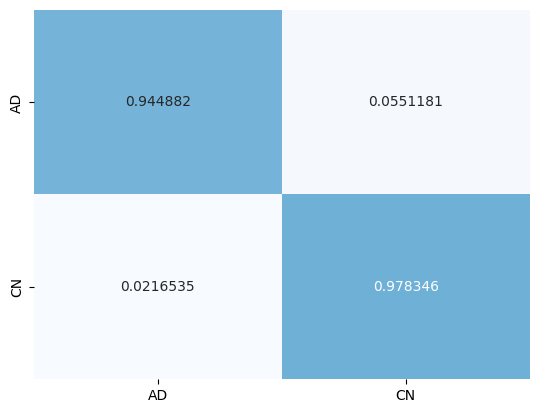

In [28]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [29]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                precision    recall  f1-score   support

          AD       0.98      0.94      0.96       508
          CN       0.95      0.98      0.96       508

    accuracy                           0.96      1016
   macro avg       0.96      0.96      0.96      1016
weighted avg       0.96      0.96      0.96      1016

